In [ ]:
! pip install --quiet einops lightning[extra]==2.0.4 torchmetrics==0.11.4 tiktoken==0.4.0 einops==0.6.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import tiktoken
import requests
import numpy as np
from pathlib import Path
from typing import Optional
from torch.utils.data import DataLoader, Dataset, random_split
from lightning import LightningDataModule


class HPDataset(Dataset):
    def __init__(self, data_dir="./data", block_size=8, text_file="data.txt",download=True):
        super().__init__()

        self.block_size = block_size
        self.data_dir = data_dir
        self.text_file = text_file


        if download:

            Path(self.data_dir).mkdir(exist_ok=True, parents=True)

            urls = [
            "https://github.com/formcept/whiteboard/raw/master/nbviewer/notebooks/data/harrypotter/Book%201%20-%20The%20Philosopher's%20Stone.txt",
            "https://github.com/formcept/whiteboard/raw/master/nbviewer/notebooks/data/harrypotter/Book%202%20-%20The%20Chamber%20of%20Secrets.txt",
            "https://github.com/formcept/whiteboard/raw/master/nbviewer/notebooks/data/harrypotter/Book%203%20-%20The%20Prisoner%20of%20Azkaban.txt",
            "https://github.com/formcept/whiteboard/raw/master/nbviewer/notebooks/data/harrypotter/Book%204%20-%20The%20Goblet%20of%20Fire.txt",
            "https://github.com/formcept/whiteboard/raw/master/nbviewer/notebooks/data/harrypotter/Book%205%20-%20The%20Order%20of%20the%20Phoenix.txt",
            "https://github.com/formcept/whiteboard/raw/master/nbviewer/notebooks/data/harrypotter/Book%206%20-%20The%20Half%20Blood%20Prince.txt",
            "https://github.com/formcept/whiteboard/raw/master/nbviewer/notebooks/data/harrypotter/Book%207%20-%20The%20Deathly%20Hallows.txt"
            ]

            for url in urls:
                res = requests.get(
                    url,
                    allow_redirects=True
                )

                with (Path(self.data_dir) / self.text_file).open("ab") as f:
                    f.write(res.content)

        with (Path(self.data_dir) / Path(self.text_file)).open() as f:
            self.text = f.read()


        cl100k_base = tiktoken.get_encoding("cl100k_base")

        # In production, load the arguments directly instead of accessing private attributes
        # See openai_public.py for examples of arguments for specific encodings
        self.encoder = tiktoken.Encoding(
            # If you're changing the set of special tokens, make sure to use a different name
            # It should be clear from the name what behaviour to expect.
            name="cl100k_im",
            pat_str=cl100k_base._pat_str,
            mergeable_ranks=cl100k_base._mergeable_ranks,
            special_tokens={
                **cl100k_base._special_tokens,
                "<|im_start|>": 100264,
                "<|im_end|>": 100265,
            }
        )

        self.data = np.array(self.encoder.encode(self.text))

    def __len__(self):
        return len(self.data) - self.block_size - 1

    def __getitem__(self, idx):
        x = torch.from_numpy(
            (self.data[idx:idx + self.block_size]).astype(np.int64)
        )

        y = torch.from_numpy(
            (self.data[idx+1:idx+1+self.block_size]).astype(np.int64)
        )

        return x, y



class HPDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str = "data/",
        text_file = "data.txt",
        train_ratio=0.7,
        batch_size: int = 256,
        block_size: int = 8,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        self.save_hyperparameters(logger=False)

        self.data_train: Optional[Dataset] = None
        self.data_val: Optional[Dataset] = None

    def prepare_data(self):
        HPDataset(data_dir=self.hparams.data_dir,
                  block_size=self.hparams.block_size,
                  text_file=self.hparams.text_file,
                  download=True)

    def setup(self, stage: Optional[str] = None):
        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_val:
            dataset = HPDataset(data_dir=self.hparams.data_dir,
                                block_size=self.hparams.block_size,
                                text_file=self.hparams.text_file,
                                download=False)

            self.data_train, self.data_val = random_split(
                dataset=dataset,
                lengths=[self.hparams.train_ratio, (1-self.hparams.train_ratio)],
                generator=torch.Generator().manual_seed(42),
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )


In [ ]:
import tiktoken, itertools
import numpy as np

from pathlib import Path

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

from einops import rearrange, reduce, repeat, einsum
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary


from torch.utils.data import Dataset, DataLoader, random_split

import lightning as L
from lightning import LightningModule, LightningDataModule
from torchmetrics import MaxMetric, MeanMetric, MinMetric

from typing import Any, Optional



class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, n_dim, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        self.n_heads = n_heads
        self.n_dim = n_dim
        self.h_dim = n_dim // n_heads

        self.keys = nn.Linear(n_dim, self.h_dim * self.n_heads)
        self.queries = nn.Linear(n_dim, self.h_dim * self.n_heads)
        self.values = nn.Linear(n_dim, self.h_dim * self.n_heads)

        self.proj = nn.Linear(n_dim, n_dim)

        self.layer_norm = nn.LayerNorm(n_dim)

        self.attn_dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask = None):
        key = rearrange(
            self.keys(x),
            'b time (nh dim) -> nh b time dim', nh=self.n_heads
        )
        query = rearrange(
            self.queries(x),
            'b time (nh dim) -> nh b time dim', nh=self.n_heads
        )
        value = rearrange(
            self.values(x),
            'b time (nh dim) -> nh b time dim', nh=self.n_heads
        )

        energies = einsum(
            query,
            key,
            'nh b qt dim, nh b kt dim -> nh b qt kt'
        )

        if mask is not None:
            fill_value = torch.finfo(energies.dtype).min
            energies = energies.masked_fill(mask, fill_value)

        attn = F.softmax(energies, dim=-1)

        attn = self.attn_dropout(attn)

        out = einsum(
            attn,
            value,
            'nh b qt kt, nh b kt dim -> nh b qt dim'
        )

        out = rearrange(
            out,
            'nh b vt dim -> b vt (nh dim)'
        )

        out = self.proj(out)

        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()

        self.fn = fn

    def forward(self, x, **kwargs):
        res = x

        out = self.fn(x, **kwargs)

        out += res

        return out


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size=768, expansion=4, drop_p=0.):
        super(FeedForwardBlock, self).__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )


class GPTDecoderBlock(nn.Module):
    def __init__(
        self,
        emb_size = 768,
        drop_p = 0.,
        forward_expansion = 4,
        forward_drop_p = 0,
        n_heads=4
    ):
        super(GPTDecoderBlock, self).__init__()

        self.ln = nn.LayerNorm(emb_size)
        self.mha = MultiHeadAttention(n_heads=n_heads, n_dim=emb_size, dropout=drop_p)
        self.drop = nn.Dropout(drop_p)

        self.out_block = ResidualAdd(
            nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
        )

    def forward(self, x, mask = None):
        residual = x

        out = self.ln(x)
        out = self.mha(out, mask)
        out = self.drop(out)
        out = x + out
        out = self.out_block(out)

        return out

class GPT(nn.Module):
    def __init__(self,
                 vocab_size,
                 block_size,
                 n_embed,
                 n_heads,
                 drop_p,
                 n_decoder_blocks):
        super(GPT, self).__init__()

        #print(vocab_size, n_embed)
        self.block_size = block_size

        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)


        self.blocks = nn.ModuleList([
            GPTDecoderBlock(emb_size=n_embed, drop_p=drop_p, n_heads=n_heads),
        ] * n_decoder_blocks)
        self.ln = nn.LayerNorm(n_embed)
        self.ffwd = FeedForwardBlock(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

        # query: what am i looking for?
        # key: what do i contain?

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        for block in self.blocks:
            x = block(x, mask)
        x = self.ln(x)
        x = self.ffwd(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature = 1.0, top_k = None):
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


class GPTLitModule(LightningModule):
    def __init__(
        self,
        learning_rate=1e-3,
        n_embed=64,
        block_size=8,
        n_heads=4,
        drop_p=0.0,
        n_vocab=100277,  # n_vocab of cl100k_base
        n_decoder_blocks=4,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        # ignoring net as the model weights themselves are not a hyperparam
        self.save_hyperparameters(logger=False, ignore=['model'])


        self.learning_rate = learning_rate

        print([(i,type(i)) for i in self.hparams])

        self.model = GPT(
            vocab_size=self.hparams.n_vocab,
            block_size=self.hparams.block_size,
            n_embed=self.hparams.n_embed,
            n_heads=self.hparams.n_heads,
            drop_p=self.hparams.drop_p,
            n_decoder_blocks=self.hparams.n_decoder_blocks)

        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation loss
        self.val_loss_best = MinMetric()

        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)) == 0)

    def forward(self, x: torch.Tensor, targets: torch.Tensor = None):
        mask = self.mask if targets is not None else None
        return self.model(x, targets=targets, mask=mask)

    def on_train_start(self):
        # by default lightning executes validation step sanity checks before training starts,
        # so it's worth to make sure validation metrics don't store results from these checks
        self.val_loss.reset()
        self.val_loss_best.reset()

    def model_step(self, batch: Any):
        x, y = batch
        logits, loss = self.forward(x, targets=y)
        return loss

    def training_step(self, batch: Any, batch_idx: int):
        loss = self.model_step(batch)

        # update and log metrics
        self.train_loss(loss)
        self.log("train/loss", self.train_loss,
                 on_step=False, on_epoch=True, prog_bar=True)

        # return loss or backpropagation will fail
        return loss

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch: Any, batch_idx: int):
        loss = self.model_step(batch)

        # update and log metrics
        self.val_loss(loss)
        self.log("val/loss", self.val_loss, on_step=False,
                 on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        loss = self.val_loss.compute()  # get current val loss
        self.val_loss_best(loss)  # update best so far val loss
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/loss_best", self.val_loss_best.compute(), sync_dist=True, prog_bar=True)

    def configure_optimizers(self):
        """Choose what optimizers and learning-rate schedulers to use in your optimization.
        Normally you'd need one. But in the case of GANs or similar you might have multiple.

        Examples:
            https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#configure-optimizers
        """
        optimizer = torch.optim.Adam(params=self.parameters(), lr=self.learning_rate)

        return {"optimizer": optimizer}

In [ ]:
model = GPTLitModule()

[('learning_rate', <class 'str'>), ('n_embed', <class 'str'>), ('block_size', <class 'str'>), ('n_heads', <class 'str'>), ('drop_p', <class 'str'>), ('n_vocab', <class 'str'>), ('n_decoder_blocks', <class 'str'>)]


In [ ]:
dataset = HPDataModule()

In [ ]:
trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model,
    dataset
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type       | Params
---------------------------------------------
0 | model         | GPT        | 13.0 M
1 | train_loss    | MeanMetric | 0     
2 | val_loss      | MeanMetric | 0     
3 | test_loss     | MeanMetric | 0     
4 | val_loss_best | MinMetric  | 0     
---------------------------------------------
13.0 M    Trainable params
0         Non-trainable params
13.0 M    Total params
52.078    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type       | Params
---------------------------------------------
0 | model         | GPT        | 13.0 M
1 | train_loss    | MeanMetric | 0     
2 | val_loss      | MeanMetric | 0     
3 | test_loss     | MeanMetric | 0     
4 | val_loss_best | MinMetric  | 0     
---------------------------------------------
13.0 M    Trainable 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# LR Finder

In [ ]:
from lightning.pytorch.tuner import Tuner

In [ ]:
tuner = Tuner(trainer)

In [ ]:
lr_finder = tuner.lr_find(model, dataset)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 90 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 90 steps due to diverging loss.
INFO: Learning rate set to 0.0003019951720402019
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0003019951720402019
INFO: Restoring states from the checkpoint path at /content/.lr_find_200e5d7b-0645-452c-b530-4ef54324b3d4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_200e5d7b-0645-452c-b530-4ef54324b3d4.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_200e5d7b-0645-452c-b530-4ef54324b3d4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_200e5d7b-0645-452c-b530-4ef54324b3d4.ckpt


In [ ]:
print(f"best initial lr={lr_finder.suggestion()}")

best initial lr=0.0003019951720402019


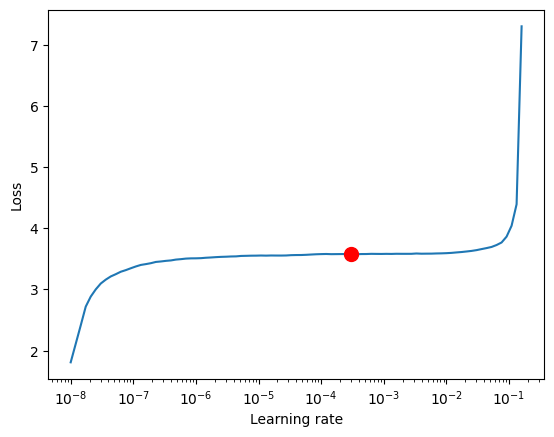

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

# batch size optimizer

In [ ]:
# Auto-scale batch size by growing it exponentially (default)
tuner.scale_batch_size(model, dataset, mode="power")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopped: `max_steps=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO: Batch size 2 succeeded, trying batch size 4
INFO:lightning.pytorch.utilities.rank_zero:Batch size 2 succeeded, trying batch size 4
INFO: `Trainer.fit` stopped: `max_steps=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO: Batch size 4 succeeded, trying batch size 8
INFO:lightning.pytorch.utilities.rank_zero:Batch size 4 succeeded, trying batch size 8
INFO: `Trainer.fit` stopped: `max_steps=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO: Batch size 8 succeeded, trying batch size 16
INFO:lightning.pytorch.utilities.rank_zero:Batch size 8 succeeded, trying batch size 16
INFO: `Trainer.fit` stopped: `max

1024

In [ ]:
print(f"optimal batch size = {dataset.hparams.batch_size}")

optimal batch size = 1024


In [ ]:
# Auto-scale batch size with binary search
tuner.scale_batch_size(model, dataset, mode="binsearch")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopped: `max_steps=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO: Batch size 2 succeeded, trying batch size 4
INFO:lightning.pytorch.utilities.rank_zero:Batch size 2 succeeded, trying batch size 4
INFO: `Trainer.fit` stopped: `max_steps=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO: Batch size 4 succeeded, trying batch size 8
INFO:lightning.pytorch.utilities.rank_zero:Batch size 4 succeeded, trying batch size 8
INFO: `Trainer.fit` stopped: `max_steps=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3` reached.
INFO: Batch size 8 succeeded, trying batch size 16
INFO:lightning.pytorch.utilities.rank_zero:Batch size 8 succeeded, trying batch size 16
INFO: `Trainer.fit` stopped: `max

1535

In [ ]:
print(f"optimal batch size = {dataset.hparams.batch_size}")

optimal batch size = 1535
